# ÈáèÂåñÁ≠ñÁï•ÂõûÊµãÊ°ÜÊû∂ - ConvLSTMÊ®°ÂûãÈõÜÊàê (V2 - Â¢ûÂä†Âõ†Â≠êÁ≠õÈÄâ)

In [23]:
# --- ÂøÖË¶ÅÁöÑÂ∫ìÂØºÂÖ• ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style, Back
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import pickle
from pathlib import Path
import warnings
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
import gc  # Áî®‰∫éÂÜÖÂ≠òÁÆ°ÁêÜ
from scipy.stats import spearmanr # ‰ªÖÁî®‰∫éÈ™åËØÅÔºåÊ†∏ÂøÉËÆ°ÁÆó‰∏çÂÜç‰æùËµñ
from tqdm import tqdm # Áî®‰∫éÊòæÁ§∫Á≠õÈÄâËøõÂ∫¶

# ÂøΩÁï•PandasÂú®ÁâπÂÆöÊìç‰Ωú‰∏≠ÂèØËÉΩ‰∫ßÁîüÁöÑÊó†ÂÆ≥Ë≠¶Âëä
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning) # ÂøΩÁï•Âú®ËÆ°ÁÆó‰∏≠ÂèØËÉΩÈÅáÂà∞ÁöÑRuntimeWarning

# ÈÖçÁΩÆÊó•ÂøóËæìÂá∫Ê†ºÂºè
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ËÆæÁΩÆÁªòÂõæÈ£éÊ†º
plt.style.use('seaborn-v0_8-darkgrid')

---
## 1. Êñ∞Â¢ûÔºö‰∏§Èò∂ÊÆµÂõ†Â≠êÁ≠õÈÄâÊ®°Âùó

ËØ•Ê®°ÂùóÂÆûÁé∞‰∫Ü‚ÄúË¥®ÈáèÊåáÊ†áÂàùÁ≠õ‚ÄùÂíå‚ÄúÂõûÊµãË°®Áé∞Á≤æÁ≠õ‚ÄùÁöÑÊºèÊñóÂºèÁ≠õÈÄâÊµÅÁ®ã„ÄÇ

In [24]:
# --- MODIFIED: ‰øÆÊ≠£Âπ∂‰ºòÂåñÂõ†Â≠êÁ≠õÈÄâÊ®°Âùó ---

def calculate_factor_metrics(factor_series, forward_returns, rolling_window=252):
    """
    ËÆ°ÁÆóÂçï‰∏™Âõ†Â≠êÁöÑÊªöÂä®Rank ICÂíåIR (‰ΩøÁî®È´òÊïàÁöÑPandasÊÉØÁî®Ê≥ï)„ÄÇ
    
    ÂèÇÊï∞:
    - factor_series (pd.Series): Âçï‰∏™Âõ†Â≠êÁöÑÊó∂Èó¥Â∫èÂàóÂÄº„ÄÇ
    - forward_returns (pd.Series): ÂØπÈΩêÁöÑÊú™Êù•Êî∂ÁõäÁéáÂ∫èÂàó„ÄÇ
    - rolling_window (int): ËÆ°ÁÆóÊªöÂä®ÊåáÊ†áÁöÑÁ™óÂè£Â§ßÂ∞è„ÄÇ
    
    ËøîÂõû:
    - tuple: (Âπ≥ÂùáRank IC, ‰ø°ÊÅØÊØîÁéá IR)
    """
    # ÂØπÈΩêÊï∞ÊçÆÔºåÂéªÈô§NaN
    data = pd.concat([factor_series, forward_returns], axis=1).dropna()
    data.columns = ['factor', 'return']

    if len(data) < rolling_window:
        return 0.0, 0.0

    # --- FIX START: ‰ΩøÁî®ÊúÄÈ´òÊïàÁöÑPandasÊÉØÁî®Ê≥ïËÆ°ÁÆóÊªöÂä®Rank IC ---
    # Ê≠•È™§1: ÂàÜÂà´ËÆ°ÁÆóÂõ†Â≠êÂíåÊî∂ÁõäÁöÑÊªöÂä®Áß©Ê¨°
    # .rank(pct=True) Â∞ÜÂÄºËΩ¨Êç¢‰∏∫0Âà∞1ÁöÑÁôæÂàÜ‰ΩçÁß©Ê¨°
    ranked_factor = data['factor'].rolling(window=rolling_window).rank(pct=True)
    ranked_return = data['return'].rolling(window=rolling_window).rank(pct=True)
    
    # Ê≠•È™§2: ËÆ°ÁÆóÊªöÂä®Áß©Ê¨°ÁöÑÁöÆÂ∞îÈÄäÁõ∏ÂÖ≥Á≥ªÊï∞ÔºåËøôÁ≠â‰ª∑‰∫éÊñØÁöÆÂ∞îÊõºÁõ∏ÂÖ≥Á≥ªÊï∞
    # rolling().corr() ÊòØÈ´òÂ∫¶‰ºòÂåñÁöÑÂáΩÊï∞
    rolling_rank_ic = ranked_factor.rolling(window=rolling_window).corr(ranked_return)
    # --- FIX END ---
    
    # ËÆ°ÁÆóÂπ≥ÂùáRank IC
    mean_rank_ic = rolling_rank_ic.mean()
    
    # ËÆ°ÁÆóIR (‰ø°ÊÅØÊØîÁéá)
    std_rank_ic = rolling_rank_ic.std()
    ir = mean_rank_ic / std_rank_ic if std_rank_ic > 0 and not np.isnan(std_rank_ic) else 0
    
    return mean_rank_ic, ir


In [25]:
def factor_to_signal(factor_series, upper_quantile=0.7, lower_quantile=0.3):
    """
    Â∞ÜËøûÁª≠ÁöÑÂõ†Â≠êÂÄºËΩ¨Êç¢‰∏∫Á¶ªÊï£ÁöÑ‰∫§Êòì‰ø°Âè∑ (1, -1, 0)„ÄÇ
    
    ÂèÇÊï∞:
    - factor_series (pd.Series): Âõ†Â≠êÂÄºÂ∫èÂàó„ÄÇ
    - upper_quantile (float): ÂÅöÂ§ö‰ø°Âè∑ÁöÑÈòàÂÄºÂàÜ‰ΩçÊï∞„ÄÇ
    - lower_quantile (float): ÂÅöÁ©∫‰ø°Âè∑ÁöÑÈòàÂÄºÂàÜ‰ΩçÊï∞„ÄÇ
    
    ËøîÂõû:
    - pd.Series: ‰∫§Êòì‰ø°Âè∑Â∫èÂàó„ÄÇ
    """
    upper_threshold = factor_series.quantile(upper_quantile)
    lower_threshold = factor_series.quantile(lower_quantile)
    
    signal = pd.Series(0, index=factor_series.index, dtype=np.int8)
    signal[factor_series > upper_threshold] = 1
    signal[factor_series < lower_threshold] = -1
    
    return signal

In [26]:
def _calculate_performance_metrics(backtest_results, trade_history, initial_capital, holding_period):
    """
    ‰∏Ä‰∏™‚ÄúÈùôÈªò‚ÄùÁöÑÊÄßËÉΩËÆ°ÁÆóÂáΩÊï∞ÔºåÁî®‰∫éÂõ†Â≠êÁ≠õÈÄâÔºåÂÆÉËøîÂõûÊåáÊ†áÂÄºËÄå‰∏çÊòØÊâìÂç∞Êä•Âëä„ÄÇ
    ÂÖ∂Ê†∏ÂøÉËÆ°ÁÆóÈÄªËæë‰∏•Ê†ºÈÅµÂæ™ÊÇ®Êèê‰æõÁöÑ `evaluate_realized_pnl_performance` ÂáΩÊï∞„ÄÇ
    """
    df = backtest_results
    trade_df = trade_history
    
    # Ê†∏ÂøÉÊî∂Áõä‰∏éÈ£éÈô©ÊåáÊ†á
    total_return = (df['equity_curve'].iloc[-1] - initial_capital) / initial_capital
    equity_curve = df['equity_curve']
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (peak - equity_curve) / peak
    max_drawdown = drawdown.max()
    
    # Âπ¥ÂåñÊåáÊ†á
    duration_years = max((df.index[-1] - df.index[0]).days / 365.25, 0.001)
    annualized_return = total_return / duration_years
    
    # Ê†áÂáÜÂåñÈ£éÈô©Ë∞ÉÊï¥ÂêéÊî∂Áõä
    monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()
    sharpe_ratio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12) if len(monthly_returns) > 1 else 0
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # ‰∫§ÊòìÁªüËÆ°
    total_trades = len(trade_df)
    expectancy = 0
    if total_trades > 0:
        winning_trades = trade_df[trade_df['net_pnl'] > 0]
        losing_trades = trade_df[trade_df['net_pnl'] <= 0]
        win_rate = len(winning_trades) / total_trades
        avg_win = winning_trades['net_pnl'].mean() / initial_capital if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['net_pnl'].mean() / initial_capital if len(losing_trades) > 0 else 0
        # ÊúüÊúõÊî∂ÁõäÂÖ¨Âºè‰∏•Ê†ºÊåâÁÖßÊÇ®Êèê‰æõÁöÑÁâàÊú¨
        profit_factor = abs(winning_trades['net_pnl'].sum() / losing_trades['net_pnl'].abs().sum()) if len(losing_trades) > 0 and losing_trades['net_pnl'].abs().sum() > 0 else float('inf')
        # ‰øÆÊ≠£ÊúüÊúõÊî∂ÁõäÂÖ¨Âºè‰ª•ÂåπÈÖçÊÇ®ÁöÑÂÆö‰πâ
        # ÊÇ®ÁöÑÂÆö‰πâÔºöÊúüÊúõÊî∂Áõä = (ËÉúÁéá * Áõà‰∫èÊØî) - (1 - ËÉúÁéá)
        # Ê≥®ÊÑèÔºöËøô‰∏™ÂÖ¨ÂºèÂú®ÈáëËûçÈ¢ÜÂüü‰∏çÂ∏∏ËßÅÔºå‰ΩÜÊàë‰ª¨‰∏•Ê†ºÈÅµÂæ™ÊÇ®ÁöÑË¶ÅÊ±Ç„ÄÇ
        # Â∏∏ËßÅÁöÑÂÖ¨ÂºèÊòØÔºö(ËÉúÁéá * Âπ≥ÂùáÁõàÂà©) - (Ë¥•Áéá * Âπ≥Âùá‰∫èÊçü)
        # Êàë‰ª¨Â∞Ü‰ΩøÁî®ÊÇ®Êèê‰æõÁöÑÂÖ¨ÂºèÔºö
        expectancy_from_formula = (win_rate * profit_factor) - (1 - win_rate) if profit_factor != float('inf') else float('inf')
    else:
        expectancy_from_formula = 0

    # ÊïàÁéáÊåáÊ†á
    weekly_trades = trade_df.resample('W', on='entry_time').size().mean() if not trade_df.empty else 0
    
    return {
        "sharpe_ratio": sharpe_ratio,
        "calmar_ratio": calmar_ratio,
        "max_drawdown": max_drawdown,
        "expectancy": expectancy_from_formula,
        "weekly_trades": weekly_trades
    }

In [27]:
def screen_factors_sequentially(factor_data, config):
    """
    ÊâßË°åÂÆåÊï¥ÁöÑ‰∏§Èò∂ÊÆµÊºèÊñóÂºèÂõ†Â≠êÁ≠õÈÄâ„ÄÇ
    """
    logging.info("===== ÂºÄÂßãÊâßË°å‰∏§Èò∂ÊÆµÂõ†Â≠êÁ≠õÈÄâÊµÅÁ®ã =====")
    
    all_factor_cols = [col for col in factor_data.columns if col.startswith('ret') or col.startswith('c_chu') or col.startswith('c_hide')]
    prices = factor_data['close']
    
    logging.info(f"--- Èò∂ÊÆµ‰∏ÄÔºöÂü∫‰∫éRank ICÂíåIRËøõË°åÂàùÁ≠õ (ÂÖ± {len(all_factor_cols)} ‰∏™Âõ†Â≠ê) ---")
    
    forward_returns = prices.pct_change(config['holding_period']).shift(-config['holding_period'])
    
    passed_first_stage = []
    
    for factor_name in tqdm(all_factor_cols, desc="Èò∂ÊÆµ‰∏ÄÁ≠õÈÄâËøõÂ∫¶"):
        factor_series = factor_data[factor_name]
        # Ê≠§Â§ÑÊòØÂÖ≥ÈîÆÔºåÂÆÉÈúÄË¶Å config['rolling_window']
        rank_ic, ir = calculate_factor_metrics(factor_series, forward_returns, rolling_window=config['rolling_window'])
        
        if abs(rank_ic) > config['rank_ic_threshold'] and abs(ir) > config['ir_threshold']:
            passed_first_stage.append(factor_name)
            
    logging.info(f"‚úÖ Èò∂ÊÆµ‰∏ÄÂÆåÊàê: {len(passed_first_stage)} / {len(all_factor_cols)} ‰∏™Âõ†Â≠êÈÄöËøáÂàùÁ≠õ„ÄÇ")
    
    if not passed_first_stage:
        logging.warning("‚ö†Ô∏è Ê≤°Êúâ‰ªª‰ΩïÂõ†Â≠êÈÄöËøáÁ¨¨‰∏ÄÈò∂ÊÆµÁ≠õÈÄâÔºåÊµÅÁ®ãÁªàÊ≠¢„ÄÇ")
        return [], []

    logging.info(f"--- Èò∂ÊÆµ‰∫åÔºöÂü∫‰∫éÂçïÂõ†Â≠êÂõûÊµãË°®Áé∞ËøõË°åÁ≤æÁ≠õ (ÂÖ± {len(passed_first_stage)} ‰∏™Âõ†Â≠ê) ---")
    
    final_selected_factors = []
    
    for factor_name in tqdm(passed_first_stage, desc="Èò∂ÊÆµ‰∫åÁ≠õÈÄâËøõÂ∫¶"):
        factor_signal = factor_to_signal(factor_data[factor_name])
        
        backtest_results, trade_history = run_realized_pnl_backtest(
            prices=prices,
            signals=factor_signal,
            initial_capital=config['initial_capital'],
            commission_rate=config['commission_rate'],
            holding_period=config['holding_period']
        )
        
        if trade_history.empty:
            continue
            
        perf = _calculate_performance_metrics(
            backtest_results, 
            trade_history, 
            config['initial_capital'],
            config['holding_period']
        )
        
        returns_ok = (perf['sharpe_ratio'] > config['sharpe_threshold'] and perf['calmar_ratio'] > config['calmar_threshold']) or \
                     (perf['expectancy'] > config['expectancy_threshold'])
        
        risk_ok = perf['max_drawdown'] < config['mdd_threshold']
        
        efficiency_ok = perf['weekly_trades'] > config['weekly_trades_threshold']
        
        if returns_ok and risk_ok and efficiency_ok:
            final_selected_factors.append(factor_name)
            logging.debug(f"  -> ‚úÖ Âõ†Â≠ê '{factor_name}' ÈÄöËøáÁ≤æÁ≠õ. Sharpe: {perf['sharpe_ratio']:.2f}, MDD: {perf['max_drawdown']:.2%}")
        else:
            logging.debug(f"  -> ‚ùå Âõ†Â≠ê '{factor_name}' Êú™ÈÄöËøáÁ≤æÁ≠õ. Sharpe: {perf['sharpe_ratio']:.2f}, MDD: {perf['max_drawdown']:.2%}")

    logging.info(f"‚úÖ Èò∂ÊÆµ‰∫åÂÆåÊàê: {len(final_selected_factors)} / {len(passed_first_stage)} ‰∏™Âõ†Â≠êÈÄöËøáÁ≤æÁ≠õ„ÄÇ")
    logging.info("===== Âõ†Â≠êÁ≠õÈÄâÊµÅÁ®ãÁªìÊùü =====")
    
    return final_selected_factors, passed_first_stage

---
## 2. ConvLSTMÊ®°ÂûãÊûÑÂª∫‰∏éËÆ≠ÁªÉ

In [28]:
def build_enhanced_conv_lstm_model(input_shape, num_features):
    """
    ÊûÑÂª∫Â¢ûÂº∫ÁâàConvLSTMÊ∑∑ÂêàÊ®°ÂûãÊû∂ÊûÑÔºåÂ§ÑÁêÜÊõ¥Â§öÂõ†Â≠ê
    
    Ê®°ÂûãÂ¢ûÂº∫ÁÇπ:
    1. Â¢ûÂä†Âç∑ÁßØÂ±ÇÈÄöÈÅìÊï∞ÂíåLSTMÂçïÂÖÉÊï∞
    2. Ê∑ªÂä†ÂèåÂêëLSTMÊçïÊçâÊõ¥Â§çÊùÇÁöÑÊó∂Â∫è‰æùËµñ
    3. ÂºïÂÖ•Ê≥®ÊÑèÂäõÊú∫Âà∂ËÅöÁÑ¶ÈáçË¶ÅÁâπÂæÅ
    4. Â¢ûÂä†ÊÆãÂ∑ÆËøûÊé•Ê∑±Â∫¶
    
    ÂèÇÊï∞:
    - input_shape: ËæìÂÖ•Êï∞ÊçÆÂΩ¢Áä∂ (Êó∂Èó¥Ê≠•Èïø, ÁâπÂæÅÊï∞)
    - num_features: ÁâπÂæÅÊï∞Èáè
    
    ËøîÂõû:
    - ÁºñËØëÂ•ΩÁöÑKerasÊ®°Âûã
    """
    from tensorflow.keras.layers import Bidirectional, Attention, Reshape
    
    # ËæìÂÖ•Â±Ç
    inputs = Input(shape=input_shape)
    
    # 1. ÁâπÂæÅÊèêÂèñÂàÜÊîØ
    # 1DÂç∑ÁßØÂàÜÊîØ - ÊèêÂèñÂ±ÄÈÉ®ÁâπÂæÅÊ®°Âºè
    conv1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.3)(conv1)
    
    conv2 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)
    
    # 2. Êó∂Â∫è‰æùËµñÂàÜÊîØ
    # ÂèåÂêëLSTMÊçïÊçâÂ§çÊùÇÊó∂Â∫èÊ®°Âºè
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm1 = BatchNormalization()(lstm1)
    lstm1 = Dropout(0.3)(lstm1)
    
    # Ê≥®ÊÑèÂäõÊú∫Âà∂ËÅöÁÑ¶ÈáçË¶ÅÊó∂Èó¥Ê≠•
    attention = Attention()([lstm1, lstm1])
    lstm2 = Bidirectional(LSTM(256, return_sequences=False))(attention)
    lstm2 = BatchNormalization()(lstm2)
    lstm2 = Dropout(0.4)(lstm2)
    
    # 3. ÂêàÂπ∂ÂàÜÊîØ
    conv_flat = Flatten()(conv2)
    merged = concatenate([conv_flat, lstm2])
    
    # 4. ÂÖ®ËøûÊé•Â±Ç
    dense1 = Dense(512, activation='relu')(merged)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(256, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.4)(dense2)
    
    # 5. ËæìÂá∫Â±Ç - ‰∏âÂàÜÁ±ª(ÂÅöÂ§ö/ÂÅöÁ©∫/‰∏≠ÊÄß)
    outputs = Dense(3, activation='softmax')(dense2)
    
    # ÂàõÂª∫Ê®°Âûã
    model = Model(inputs=inputs, outputs=outputs)
    
    # ÁºñËØëÊ®°Âûã
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [29]:
def prepare_rolling_data(factor_data, selected_features, lookback=60, test_size=0.2):
    """
    ÂáÜÂ§áÊªöÂä®ËÆ≠ÁªÉÊï∞ÊçÆ - ‰ΩøÁî®Á≠õÈÄâÂêéÁöÑÁ≤æËã±Âõ†Â≠ê (Â∑≤‰øÆÊ≠£Á¥¢ÂºïÈîôËØØ)
    """
    logging.info("üìä ÂáÜÂ§áÊªöÂä®ËÆ≠ÁªÉÊï∞ÊçÆ (‰ΩøÁî®Á≠õÈÄâÂêéÁöÑÁ≤æËã±Âõ†Â≠ê)...")
    
    feature_columns = selected_features
    
    if not feature_columns:
        raise ValueError("ÈîôËØØÔºöÊ≤°ÊúâÂèØÁî®ÁöÑÁâπÂæÅ„ÄÇÂõ†Â≠êÁ≠õÈÄâÂêéÂàóË°®‰∏∫Á©∫„ÄÇ")
        
    logging.info(f"‚úÖ ‰ΩøÁî® {len(feature_columns)} ‰∏™Á≤æËã±Âõ†Â≠êÁâπÂæÅ")
    
    # --- FIX: ‰ΩøÁî®Êé®ËçêÁöÑ ffill() ---
    features = factor_data[feature_columns].ffill().fillna(0)
    
    # ÂàõÂª∫ÁõÆÊ†áÂèòÈáè
    future_returns = np.log(factor_data['close']).diff(10).shift(-10)
    volatility = future_returns.rolling(100).std().fillna(0.01)
    upper_threshold = 0.75 * volatility
    lower_threshold = -0.75 * volatility
    
    # ÂàõÂª∫‰∏Ä‰∏™‰∏¥Êó∂ÁöÑ1D SeriesÁî®‰∫éÂØπÈΩê
    y_series = pd.Series(0, index=factor_data.index)
    y_series[future_returns > upper_threshold] = 1
    y_series[future_returns < lower_threshold] = 2
    
    # --- FIX START: ‰øÆÊ≠£Ê†∏ÂøÉÂØπÈΩêÈÄªËæë ---
    
    # 1. ÂÖàÂ∞ÜÁâπÂæÅÂíå1DÁöÑy_seriesÂØπÈΩêÔºåÂæóÂà∞Ê≠£Á°ÆÁöÑÁ¥¢Âºï
    aligned_features, aligned_y_series = features.align(y_series, join='inner', axis=0)
    
    # 2. ‰ΩøÁî®ÂØπÈΩêÂêéÁöÑÁ¥¢ÂºïÔºå‰ªéÂéüÂßãÁöÑfactor_data‰∏≠ÈáçÊñ∞ËÆ°ÁÆó‰∏Ä‰∏™ÂÆåÂÖ®ÂØπÈΩêÁöÑyÔºåÂπ∂ËΩ¨Êç¢‰∏∫ÂàÜÁ±ªÊ†ºÂºè
    # ËøôÊ†∑ÂèØ‰ª•Á°Æ‰øùy_categorical‰∏éaligned_featuresÁöÑË°å‰∏Ä‰∏ÄÂØπÂ∫î
    aligned_y_categorical = tf.keras.utils.to_categorical(aligned_y_series.values, num_classes=3)

    # 3. Áé∞Âú®Ôºåaligned_features Âíå aligned_y_categorical ÊòØÂÆåÂÖ®ÂêåÊ≠•ÁöÑ
    
    # ÁâπÂæÅÈÄâÊã©‰∏éÈôçÁª¥
    k_best = min(100, len(feature_columns))
    selector = SelectKBest(f_classif, k=k_best)
    features_selected = selector.fit_transform(aligned_features, aligned_y_series)
    
    pca = PCA(n_components=0.95)
    features_reduced = pca.fit_transform(features_selected)
    
    logging.info(f"‚úÖ ÈôçÁª¥ÂêéÁâπÂæÅÊï∞: {features_reduced.shape[1]}")
    
    # ÂàõÂª∫Êó∂Èó¥Â∫èÂàóÊ†∑Êú¨
    X = []
    valid_indices = []
    
    for i in range(lookback, len(features_reduced) - 10):
        X.append(features_reduced[i-lookback:i])
        valid_indices.append(i)
    
    X = np.array(X)
    
    # 4. Áé∞Âú®ÂèØ‰ª•ÂÆâÂÖ®Âú∞‰ΩøÁî®Êï¥Êï∞ÂàóË°® valid_indices Êù•Á¥¢ÂºïÂ∑≤ÁªèÂØπÈΩêÂ•ΩÁöÑÊï∞ÊçÆ
    y = aligned_y_categorical[valid_indices]
    indices = aligned_features.index[valid_indices]
    
    # --- FIX END ---
    
    logging.info(f"‚úÖ Êï∞ÊçÆÂáÜÂ§áÂÆåÊàê - Ê†∑Êú¨Êï∞: {X.shape[0]}, Êó∂Èó¥Ê≠•Èïø: {X.shape[1]}, ÁâπÂæÅÊï∞: {X.shape[2]}")
    return X, y, indices, pca, selector

In [30]:
def rolling_train_and_predict(X, y, indices, lookback=60, n_splits=5):
    """
    ÊâßË°åÊªöÂä®ËÆ≠ÁªÉÂíåÈ¢ÑÊµã (Â¢ûÂº∫Áâà)
    
    Â¢ûÂº∫ÁÇπ:
    1. ‰ΩøÁî®Â¢ûÂº∫ÁâàÊ®°Âûã
    2. Êõ¥Êó©ÂÅúÊ≠¢ÂíåÂä®ÊÄÅÂ≠¶‰π†ÁéáË∞ÉÊï¥
    3. Êõ¥Á≤æÁªÜÁöÑ‰ø°Âè∑Â§ÑÁêÜ
    
    ÂèÇÊï∞:
    - X: ÁâπÂæÅÊï∞ÊçÆ
    - y: Ê†áÁ≠æÊï∞ÊçÆ
    - indices: Êó∂Èó¥Á¥¢Âºï
    - lookback: ÂõûÁúãÊó∂Èó¥Ê≠•Èïø
    - n_splits: Êó∂Èó¥Â∫èÂàóÂàÜÂâ≤Êï∞
    
    ËøîÂõû:
    - È¢ÑÊµã‰ø°Âè∑Series
    """
    logging.info(f"üöÄ ÂºÄÂßãÊªöÂä®ËÆ≠ÁªÉ (n_splits={n_splits})...")
    
    # ÂàùÂßãÂåñÈ¢ÑÊµãÁªìÊûúÊï∞ÁªÑ
    all_predictions = np.zeros((len(y), 3))
    
    # ÂàõÂª∫Êó∂Èó¥Â∫èÂàó‰∫§ÂèâÈ™åËØÅÂô®
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Áî®‰∫éÂ≠òÂÇ®ÊØè‰∏™ÊäòÂè†ÁöÑÊÄßËÉΩ
    fold_accuracies = []
    fold_losses = []
    
    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        logging.info(f"\nüîÅ Â§ÑÁêÜÊäòÂè† {fold+1}/{n_splits}")
        logging.info(f"  ËÆ≠ÁªÉÈõÜ: {indices[train_index[0]]} Âà∞ {indices[train_index[-1]]}")
        logging.info(f"  ÊµãËØïÈõÜ: {indices[test_index[0]]} Âà∞ {indices[test_index[-1]]}")
        
        # ÂàíÂàÜËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Ê†áÂáÜÂåñ - ‰ΩøÁî®ËÆ≠ÁªÉÈõÜÁöÑÁªüËÆ°Èáè
        scaler = StandardScaler()
        X_train_2d = X_train.reshape(-1, X_train.shape[-1])
        X_test_2d = X_test.reshape(-1, X_test.shape[-1])
        
        scaler.fit(X_train_2d)
        X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape)
        X_test_scaled = scaler.transform(X_test_2d).reshape(X_test.shape)
        
        # ÊûÑÂª∫Â¢ûÂº∫ÁâàÊ®°Âûã
        model = build_enhanced_conv_lstm_model((lookback, X_train.shape[2]), X_train.shape[2])
        
        # ÂõûË∞ÉÂáΩÊï∞ - Êõ¥Êó©ÂÅúÊ≠¢ÂíåÂä®ÊÄÅÂ≠¶‰π†Áéá
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
        ]
        
        # ËÆ≠ÁªÉÊ®°Âûã - Â¢ûÂä†epochs
        history = model.fit(
            X_train_scaled, y_train,
            epochs=50,
            batch_size=1024,
            validation_data=(X_test_scaled, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        # Âú®ÊµãËØïÈõÜ‰∏äÈ¢ÑÊµã
        test_pred = model.predict(X_test_scaled, batch_size=2048, verbose=0)
        all_predictions[test_index] = test_pred
        
        # ËØÑ‰º∞ÊÄßËÉΩ
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
        fold_accuracies.append(test_acc)
        fold_losses.append(test_loss)
        logging.info(f"  ÊµãËØïÂáÜÁ°ÆÁéá: {test_acc:.4f}, ÊµãËØïÊçüÂ§±: {test_loss:.4f}")
        
        # Ê∏ÖÁêÜÂÜÖÂ≠ò
        del model, X_train, X_test, y_train, y_test
        gc.collect()
        tf.keras.backend.clear_session()
    
    # ÊâìÂç∞Êï¥‰ΩìÊÄßËÉΩ
    logging.info(f"\n‚úÖ ÊªöÂä®ËÆ≠ÁªÉÂÆåÊàê - Âπ≥ÂùáÂáÜÁ°ÆÁéá: {np.mean(fold_accuracies):.4f}, Âπ≥ÂùáÊçüÂ§±: {np.mean(fold_losses):.4f}")
    
    # ËΩ¨Êç¢È¢ÑÊµãÁªìÊûú‰∏∫‰ø°Âè∑
    signal_probs = all_predictions[:, 1] - all_predictions[:, 2]  # ÂÅöÂ§öÊ¶ÇÁéá - ÂÅöÁ©∫Ê¶ÇÁéá
    
    # ÂàõÂª∫‰ø°Âè∑Series
    signal_series = pd.Series(signal_probs, index=indices, name='signal_strength')
    
    # ‰ΩøÁî®Âä®ÊÄÅÈòàÂÄºÁîüÊàê‰∫§Êòì‰ø°Âè∑
    rolling_mean = signal_series.rolling(window=100).mean()
    rolling_std = signal_series.rolling(window=100).std()
    
    # Âä®ÊÄÅÈòàÂÄº
    long_threshold = rolling_mean + 0.5 * rolling_std
    short_threshold = rolling_mean - 0.5 * rolling_std
    
    # ÁîüÊàêÊúÄÁªà‰ø°Âè∑
    signals = pd.Series(0, index=indices)
    signals[signal_series > long_threshold] = 1
    signals[signal_series < short_threshold] = -1
    
    # ‰ø°Âè∑Âπ≥Êªë - ÈÅøÂÖçÈ¢ëÁπÅÂèòÂä®
    signals = signals.rolling(window=5, min_periods=3).mean()
    signals = np.where(signals > 0.3, 1, np.where(signals < -0.3, -1, 0))
    
    signal_series = pd.Series(signals, index=indices)
    
    logging.info(f"üì° ‰ø°Âè∑ÁîüÊàêÂÆåÊàê - ÂÅöÂ§öÊØî‰æã: {(signal_series == 1).mean():.2%}, "
                 f"ÂÅöÁ©∫ÊØî‰æã: {(signal_series == -1).mean():.2%}")
    
    return signal_series

## 3. Ê†∏ÂøÉÂõûÊµã‰∏éËØÑ‰º∞ÂáΩÊï∞ (‰øùÊåÅ‰∏çÂèò)
(Ê≠§Â§Ñ‰øùÁïôÂéüÊúâÁöÑrun_realized_pnl_backtestÂíåevaluate_realized_pnl_performanceÂáΩÊï∞)

In [31]:
def run_realized_pnl_backtest(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    ÊâßË°åÂü∫‰∫éÂ∑≤ÂÆûÁé∞Áõà‰∫èÁöÑÈ´òÊÄßËÉΩÂõûÊµã„ÄÇ

    Êú¨ÂáΩÊï∞‰∏∫ÂõûÊµãÊ°ÜÊû∂ÁöÑÊ†∏ÂøÉÔºåÂÖ∂ËÆæËÆ°‰∏•Ê†ºÈÅµÂæ™‰ª•‰∏ã‰∫§ÊòìÈÄªËæëÔºö
    1. **ËµÑÈáëÁÆ°ÁêÜ**: ÂàùÂßãËµÑÈáëË¢´Á≠âÂàÜ‰∏∫10‰ªΩÔºåÊØèÊ¨°ÂºÄ‰ªì‰ΩøÁî®‰∏Ä‰ªΩÔºåÁî®‰∫éÊ®°ÊãüÂàÜÊâπÂª∫‰ªì„ÄÇ
    2. **ÂçïÂêëÊåÅ‰ªì**: Âú®‰ªª‰ΩïÊó∂Èó¥ÁÇπÔºåÊâÄÊúâÊåÅ‰ªìÁöÑÊñπÂêëÂøÖÈ°ª‰∏ÄËá¥ÔºàÂÖ®‰∏∫Â§öÂ§¥ÊàñÂÖ®‰∏∫Á©∫Â§¥ÔºâÔºå‰∏çÂÖÅËÆ∏ÈîÅ‰ªìÊàñÂêåÊó∂ÊåÅÊúâÂ§öÁ©∫„ÄÇ
    3. **‰∫ã‰ª∂È©±Âä®**: ‰∫§Êòì‰ø°Âè∑Âú®t-1Êó∂Âàª‰∫ßÁîüÔºåÂú®tÊó∂ÂàªÊâßË°å„ÄÇ
    4. **Âõ∫ÂÆöÊåÅÊúâÊúü**: ÊØè‰ªΩÁã¨Á´ãÁöÑ‰ªì‰ΩçÊúÄÂ§öÊåÅÊúâ`holding_period`‰∏™Âë®ÊúüÔºåÂà∞ÊúüÂêéËá™Âä®Âπ≥‰ªì„ÄÇ
    5. **Ê∏êËøõÂºèË∞É‰ªì**: ÂΩìÊî∂Âà∞‰∏éÂΩìÂâçÊåÅ‰ªìÊñπÂêëÁõ∏ÂèçÁöÑ‰ø°Âè∑Êó∂Ôºå‰ªÖÂπ≥Êéâ**ÊúÄÊó©ÂºÄÁ´ã**ÁöÑ‰∏Ä‰ªΩ‰ªì‰ΩçÔºåËÄåÈùûÂÖ®ÈÉ®Âπ≥‰ªìÔºå‰ª•ÂÆûÁé∞Êõ¥Âπ≥ÊªëÁöÑË∞É‰ªìÔºåÂáèÂ∞ë‰∫§ÊòìÂÜ≤Âáª„ÄÇ
    6. **Â∑≤ÂÆûÁé∞Áõà‰∫è**: ÊùÉÁõäÊõ≤Á∫øÁöÑËÆ°ÁÆóÂÆåÂÖ®Âü∫‰∫éÂ∑≤ÂÖ≥Èó≠‰ªì‰ΩçÁöÑÁúüÂÆûÁõà‰∫èÔºåÂøΩÁï•Êú™Âπ≥‰ªì‰ΩçÁöÑÊµÆÂä®Áõà‰∫èÔºå‰ΩøÁªìÊûúÊõ¥‰øùÂÆàÁ®≥ÂÅ•„ÄÇ

    ÊÄßËÉΩ‰ºòÂåñÂÖ≥ÈîÆÁÇπ:
    - **È¢ÑÂàÜÈÖçÊï∞ÁªÑ**: ‰ΩøÁî®NumPyÊï∞ÁªÑÈ¢ÑÂÖàÂàÜÈÖçÂÜÖÂ≠òÊù•Â≠òÂÇ®ÂõûÊµãÁªìÊûúÔºåÈÅøÂÖçÂú®Âæ™ÁéØ‰∏≠Âä®ÊÄÅ‰øÆÊîπPandas DataFrameÔºåËøôÊòØ‰∏ªË¶ÅÁöÑÊÄßËÉΩÊèêÂçáÊù•Ê∫ê„ÄÇ
    - **È´òÊïàÈòüÂàóÊìç‰Ωú**: Âà©Áî®`collections.deque`ÁöÑO(1)Êó∂Èó¥Â§çÊùÇÂ∫¶ÁöÑ`popleft()`Âíå`append()`Êìç‰ΩúÁÆ°ÁêÜÊ¥ªË∑É‰ªì‰Ωç„ÄÇ
    - **ÁÆóÊ≥ï‰ºòÂåñ**: Ê£ÄÊü•Âà∞Êúü‰ªì‰ΩçÊó∂Ôºå‰ªÖÈúÄÊ£ÄÊü•ÈòüÂàóÂ§¥ÈÉ®ÁöÑÊúÄÊó©‰ªì‰ΩçÔºåÊó†ÈúÄÈÅçÂéÜÊï¥‰∏™ÈòüÂàó„ÄÇ

    ÂèÇÊï∞:
    - prices (pd.Series): ËµÑ‰∫ßÁöÑÊî∂Áõò‰ª∑Â∫èÂàó„ÄÇ
    - signals (pd.Series): ‰∫§Êòì‰ø°Âè∑Â∫èÂàó (1: ÂÅöÂ§ö, -1: ÂÅöÁ©∫, 0: ‰∏≠ÊÄß)„ÄÇ
    - initial_capital (float): ÂàùÂßãÊÄªËµÑÊú¨„ÄÇ
    - commission_rate (float): ÂçïËæπ‰∫§ÊòìÊâãÁª≠Ë¥πÁéá„ÄÇ
    - holding_period (int): ÊØè‰ªΩ‰ªì‰ΩçÁöÑÊúÄÂ§ßÊåÅÊúâÂë®ÊúüÔºàÂçï‰ΩçÔºöKÁ∫øÊï∞ÈáèÔºâ„ÄÇ

    ËøîÂõû:
    - pd.DataFrame: ÂåÖÂê´ÂõûÊµãËØ¶ÁªÜËøáÁ®ãÔºàÂ¶ÇÊåÅ‰ªì„ÄÅÊàêÊú¨„ÄÅÊùÉÁõäÁ≠âÔºâÁöÑDataFrame„ÄÇ
    - pd.DataFrame: ÂåÖÂê´ÊØè‰∏ÄÁ¨îÂ∑≤ÂÆåÊàê‰∫§ÊòìÁöÑËØ¶ÁªÜÂéÜÂè≤ËÆ∞ÂΩï„ÄÇ
    """
    logging.info("üöÄ ÂºÄÂßãÊâßË°å‰ºòÂåñÁâàÂõûÊµã (Âü∫‰∫éÂ∑≤ÂÆûÁé∞Áõà‰∫è)...")

    n = len(prices)
    # --- ÊÄßËÉΩ‰ºòÂåñ: È¢ÑÂàÜÈÖçÁªìÊûúÂ≠òÂÇ® ---
    # Â∞ÜÁªìÊûúÂ≠òÂÇ®Âú®Â≠óÂÖ∏ÂåÖË£πÁöÑNumPyÊï∞ÁªÑ‰∏≠ÔºåÂæ™ÁéØÁªìÊùüÂêé‰∏ÄÊ¨°ÊÄßÁîüÊàêDataFrame„ÄÇ
    # ËøôÊØîÂú®Âæ™ÁéØ‰∏≠ÈÄêË°åÂ°´ÂÖÖDataFrameÔºàÂ¶Ç‰ΩøÁî®.atÊàñ.locÔºâÂø´Âá†‰∏™Êï∞ÈáèÁ∫ß„ÄÇ
    results = {
        'position': np.zeros(n, dtype=np.int8),
        'position_count': np.zeros(n, dtype=np.int8),
        'cost_basis': np.zeros(n),
        'transaction_costs': np.zeros(n),
        'net_returns': np.zeros(n),
        'equity_curve': np.full(n, initial_capital)
    }

    # --- ÊÄßËÉΩ‰ºòÂåñ: È¢ÑÊèêÂèñÊï∞ÊçÆÂà∞NumPyÊï∞ÁªÑ ---
    # Âú®Âæ™ÁéØÂºÄÂßãÂâçÂ∞ÜPandas SeriesËΩ¨Êç¢‰∏∫NumPyÊï∞ÁªÑÔºåÂêéÁª≠Âú®Âæ™ÁéØ‰∏≠ËÆøÈóÆÊï∞ÁªÑÂÖÉÁ¥†ÊØîËÆøÈóÆSeriesÂÖÉÁ¥†Êõ¥Âø´„ÄÇ
    close_arr = prices.values
    signal_arr = signals.values
    indices = prices.index # È¢ÑÂ≠òÁ¥¢ÂºïÔºåÁî®‰∫éËÆ∞ÂΩï‰∫§ÊòìÂéÜÂè≤

    # --- ÂàùÂßãÂåñ‰∫§ÊòìÁä∂ÊÄÅÂèòÈáè ---
    active_positions = deque()  # ‰ΩøÁî®ÂèåÁ´ØÈòüÂàó(deque)È´òÊïàÁÆ°ÁêÜÂÖàËøõÂÖàÂá∫ÁöÑÊåÅ‰ªì
    realized_pnl = 0.0          # Á¥ØËÆ°Â∑≤ÂÆûÁé∞Áõà‰∫è
    position_direction = 0      # ÂΩìÂâçÊï¥‰ΩìÊåÅ‰ªìÊñπÂêë (1: Â§ö, -1: Á©∫, 0: Êó†)
    position_cost = 0.0         # ÂΩìÂâçÊåÅ‰ªìÁöÑÂπ≥ÂùáÊàêÊú¨‰ª∑
    trade_history = []          # ËÆ∞ÂΩïÊØè‰∏ÄÁ¨îÂÆåÊï¥‰∫§ÊòìÁöÑÂàóË°®
    capital_per_position = initial_capital / 10 # ÊØè‰ªΩ‰ªì‰ΩçÂàÜÈÖçÁöÑËµÑÈáë

    # --- ‰∏ªÂõûÊµãÂæ™ÁéØ ---
    # ‰ªéÁ¨¨‰∫å‰∏™Êó∂Èó¥ÁÇπÂºÄÂßãÈÅçÂéÜÔºåÂõ†‰∏∫‰∫§ÊòìÂÜ≥Á≠ñÂü∫‰∫éÂâç‰∏ÄÂ§©ÁöÑ‰ø°Âè∑
    for i in range(1, n):
        current_close = close_arr[i]
        prev_signal = signal_arr[i-1]  # ‰ΩøÁî®t-1ÁöÑ‰ø°Âè∑ÂÜ≥ÂÆötÊó∂ÂàªÁöÑÊìç‰Ωú
        trades_occurred = False        # Ê†áËÆ∞ÂΩìÊó•ÊòØÂê¶Êúâ‰∫§ÊòìÔºàÂπ≥‰ªìÔºâÂèëÁîü

        # 1. Â§ÑÁêÜÂà∞ÊúüÂº∫Âà∂Âπ≥‰ªì
        # --- ÊÄßËÉΩ‰ºòÂåñ: O(1)Â§çÊùÇÂ∫¶ÁöÑÂà∞ÊúüÊ£ÄÊü• ---
        # Áî±‰∫éactive_positionsÊòØÂÖàËøõÂÖàÂá∫ÈòüÂàóÔºåÊàë‰ª¨Âè™ÈúÄÊ£ÄÊü•ÈòüÂ§¥ÔºàÊúÄÊó©ÁöÑ‰ªì‰ΩçÔºâ„ÄÇ
        # Â¶ÇÊûúÈòüÂ§¥Ê≤°Âà∞ÊúüÔºåÈÇ£‰πàÈòüÂàó‰∏≠ÊâÄÊúâÂÖ∂‰ªñ‰ªì‰Ωç‰πü‰∏ÄÂÆöÊ≤°Âà∞Êúü„ÄÇ
        while active_positions:
            oldest_pos = active_positions[0] # Âè™Áúã‰∏çÂèñ
            if i - oldest_pos['entry_index'] >= holding_period:
                # ‰ªì‰ΩçÂ∑≤Âà∞ÊúüÔºåÊâßË°åÂπ≥‰ªì
                pos_to_close = active_positions.popleft() # ‰ªéÈòüÂàó‰∏≠ÁßªÈô§
                exit_price = current_close
                
                # ËÆ°ÁÆóÁõà‰∫è
                pnl = (exit_price - pos_to_close['entry_price']) * pos_to_close['direction'] * pos_to_close['quantity']
                exit_commission = commission_rate * exit_price * pos_to_close['quantity']
                net_pnl = pnl - exit_commission
                
                # Êõ¥Êñ∞Á¥ØËÆ°Â∑≤ÂÆûÁé∞Áõà‰∫è
                realized_pnl += net_pnl
                trades_occurred = True
                
                # ËÆ∞ÂΩï‰∫§ÊòìÊàêÊú¨
                results['transaction_costs'][i] += exit_commission
                
                # ËÆ∞ÂΩï‰∫§ÊòìÂéÜÂè≤
                trade_history.append({
                    'entry_time': indices[pos_to_close['entry_index']], 'exit_time': indices[i],
                    'direction': pos_to_close['direction'], 'entry_price': pos_to_close['entry_price'],
                    'exit_price': exit_price, 'quantity': pos_to_close['quantity'],
                    'pnl': pnl, 'commission': exit_commission, 'net_pnl': net_pnl,
                    'duration': i - pos_to_close['entry_index'], 'type': 'expired'
                })
            else:
                # ÊúÄÊó©ÁöÑ‰ªì‰ΩçÈÉΩÊú™Âà∞ÊúüÔºåÂàôÊó†ÈúÄÁªßÁª≠Ê£ÄÊü•
                break

        # 2. Ê†πÊçÆÊñ∞‰ø°Âè∑Â§ÑÁêÜ‰∫§Êòì
        if prev_signal != 0:  # Âè™ÂØπÈùû‰∏≠ÊÄß‰ø°Âè∑ÂÅöÂá∫ÂèçÂ∫î
            # ÊÉÖÂÜµA: ÂΩìÂâçÊó†‰ªª‰ΩïÊåÅ‰ªìÔºå‰∏îÊúâÊñ∞‰ø°Âè∑
            if position_direction == 0:
                # ÂºÄÁ´ãÁ¨¨‰∏Ä‰ªΩ‰ªì‰Ωç
                quantity = capital_per_position / current_close
                active_positions.append({
                    'direction': prev_signal,
                    'entry_price': current_close,
                    'quantity': quantity,
                    'entry_index': i
                })
                position_direction = prev_signal
                position_cost = current_close
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal

            # ÊÉÖÂÜµB: Êñ∞‰ø°Âè∑‰∏éÂΩìÂâçÊåÅ‰ªìÊñπÂêëÁõ∏Âêå (Âä†‰ªì)
            elif position_direction == prev_signal and len(active_positions) < 10:
                # Â¶ÇÊûú‰ªì‰ΩçÊú™Êª°10‰ªΩÔºåÂàôÂä†ÂºÄ‰∏Ä‰ªΩÊñ∞‰ªì
                quantity = capital_per_position / current_close
                active_positions.append({
                    'direction': prev_signal, 'entry_price': current_close,
                    'quantity': quantity, 'entry_index': i
                })
                # Êõ¥Êñ∞Âπ≥ÂùáÊåÅ‰ªìÊàêÊú¨
                total_quantity = sum(p['quantity'] for p in active_positions)
                total_cost = sum(p['entry_price'] * p['quantity'] for p in active_positions)
                position_cost = total_cost / total_quantity
                entry_commission = commission_rate * current_close * quantity
                results['transaction_costs'][i] += entry_commission
                results['position'][i] = prev_signal

            # ÊÉÖÂÜµC: Êñ∞‰ø°Âè∑‰∏éÂΩìÂâçÊåÅ‰ªìÊñπÂêëÁõ∏Âèç (ÈÉ®ÂàÜÂπ≥‰ªì)
            elif position_direction != prev_signal and active_positions:
                # Ê†∏ÂøÉÈÄªËæëÔºöÂè™Âπ≥ÊéâÊúÄÊó©ÁöÑ‰∏Ä‰ªΩ‰ªì‰ΩçÔºåÂÆûÁé∞Ê∏êËøõÂºèË∞É‰ªì
                pos_to_close = active_positions.popleft()
                exit_price = current_close
                pnl = (exit_price - pos_to_close['entry_price']) * pos_to_close['direction'] * pos_to_close['quantity']
                exit_commission = commission_rate * exit_price * pos_to_close['quantity']
                net_pnl = pnl - exit_commission

                realized_pnl += net_pnl
                trades_occurred = True
                results['transaction_costs'][i] += exit_commission

                trade_history.append({
                    'entry_time': indices[pos_to_close['entry_index']], 'exit_time': indices[i],
                    'direction': pos_to_close['direction'], 'entry_price': pos_to_close['entry_price'],
                    'exit_price': exit_price, 'quantity': pos_to_close['quantity'],
                    'pnl': pnl, 'commission': exit_commission, 'net_pnl': net_pnl,
                    'duration': i - pos_to_close['entry_index'], 'type': 'signal'
                })

                # Êõ¥Êñ∞ÊåÅ‰ªìÁä∂ÊÄÅ
                if active_positions:
                    # Â¶ÇÊûúÂπ≥‰ªìÂêé‰ªçÊúâÊåÅ‰ªìÔºåÈáçÊñ∞ËÆ°ÁÆóÂπ≥ÂùáÊàêÊú¨
                    total_quantity = sum(p['quantity'] for p in active_positions)
                    total_cost = sum(p['entry_price'] * p['quantity'] for p in active_positions)
                    position_cost = total_cost / total_quantity
                else:
                    # Â¶ÇÊûúÊâÄÊúâ‰ªì‰ΩçÈÉΩÂ∑≤Âπ≥ÊéâÔºåÈáçÁΩÆÊåÅ‰ªìÁä∂ÊÄÅ
                    position_direction = 0
                    position_cost = 0.0
                results['position'][i] = position_direction

        # 3. Êõ¥Êñ∞ÊØèÊó•Áä∂ÊÄÅ
        results['position_count'][i] = len(active_positions)
        results['cost_basis'][i] = position_cost
        results['equity_curve'][i] = initial_capital + realized_pnl # ÊùÉÁõäÊõ≤Á∫ø‰ªÖÈöèÂ∑≤ÂÆûÁé∞Áõà‰∫èÂèòÂåñ

        # 4. ËÆ°ÁÆóÂΩìÊó•ÂáÄÊî∂ÁõäÁéá (‰ªÖÂú®ÊúâÂπ≥‰ªì‰∫§ÊòìÊó∂ÂèëÁîüÂèòÂåñ)
        if i > 0: # ‰ªéÁ¨¨‰∫åÂ§©ÂºÄÂßãËÆ°ÁÆó
            prev_equity = results['equity_curve'][i-1]
            if trades_occurred:
                results['net_returns'][i] = (results['equity_curve'][i] - prev_equity) / prev_equity
            # Â¶ÇÊûúÊ≤°Êúâ‰∫§ÊòìÔºåÂáÄÊî∂Áõä‰∏∫0ÔºåÊï∞ÁªÑÈªòËÆ§Â∞±ÊòØ0ÔºåÊó†ÈúÄÊìç‰Ωú

    # --- ÂõûÊµãÊúüÊú´Â§ÑÁêÜ ---
    # Â∞ÜÊâÄÊúâÂâ©‰ΩôÁöÑÊú™Âπ≥‰ªìÂ§¥ÂØ∏Âú®ÊúÄÂêé‰∏Ä‰∏™‰∫§ÊòìÊó•Âº∫Âà∂Âπ≥‰ªì
    if active_positions:
        last_close = close_arr[-1]
        for pos in active_positions:
            exit_price = last_close
            pnl = (exit_price - pos['entry_price']) * pos['direction'] * pos['quantity']
            exit_commission = commission_rate * exit_price * pos['quantity']
            net_pnl = pnl - exit_commission
            realized_pnl += net_pnl
            results['transaction_costs'][-1] += exit_commission

            trade_history.append({
                'entry_time': indices[pos['entry_index']],
                'exit_time': indices[-1],
                'direction': pos['direction'],
                'entry_price': pos['entry_price'],
                'exit_price': exit_price,
                'quantity': pos['quantity'],
                'pnl': pnl,
                'commission': exit_commission,
                'net_pnl': net_pnl,
                'duration': n - 1 - pos['entry_index'],
                'type': 'forced_close'
            })
            
        # Êõ¥Êñ∞ÊúÄÁªàÁöÑÊùÉÁõäÂíåÊî∂ÁõäÁéá
        results['equity_curve'][-1] = initial_capital + realized_pnl
        prev_equity = results['equity_curve'][-2] if n > 1 else initial_capital
        results['net_returns'][-1] = (results['equity_curve'][-1] - prev_equity) / prev_equity

    # --- Êï¥ÂêàÁªìÊûú ---
    # ‰ΩøÁî®È¢ÑÂÖàËÆ°ÁÆóÂ•ΩÁöÑNumPyÊï∞ÁªÑÔºå‰∏ÄÊ¨°ÊÄßÂàõÂª∫ÊúÄÁªàÁöÑDataFrame
    df = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': results['position'],
        'position_count': results['position_count'],
        'cost_basis': results['cost_basis'],
        'transaction_costs': results['transaction_costs'],
        'net_returns': results['net_returns'],
        'equity_curve': results['equity_curve']
    }, index=prices.index)

    logging.info("‚úÖ ‰ºòÂåñÁâàÂõûÊµãÂÆåÊàê„ÄÇ")
    return df, pd.DataFrame(trade_history)

In [32]:
def evaluate_realized_pnl_performance(backtest_results, trade_history, initial_capital):
    """
    ÂÖ®Èù¢ËØÑ‰º∞Âü∫‰∫éÂ∑≤ÂÆûÁé∞Áõà‰∫èÁöÑÁ≠ñÁï•Ë°®Áé∞ÔºåÂπ∂ÁîüÊàêÊ†áÂáÜÂåñÊä•Âëä„ÄÇ

    ÂÖ≥ÈîÆËØÑ‰º∞ÈÄªËæë:
    - **Ê†áÂáÜÂåñÊåáÊ†á**: Â§èÊôÆÊØîÁéáÁ≠âÂÖ≥ÈîÆÈ£éÈô©ÊåáÊ†áÂü∫‰∫éÊúàÂ∫¶Êî∂ÁõäÁéáËÆ°ÁÆóÔºå‰ª•Êèê‰æõÊõ¥Á®≥ÂÅ•„ÄÅÊõ¥ÂÖ∑ÂèØÊØîÊÄßÁöÑËØÑ‰º∞„ÄÇ
    - **ÂêëÈáèÂåñËÆ°ÁÆó**: Â∞ΩÂèØËÉΩ‰ΩøÁî®PandasÂíåNumPyÁöÑÂêëÈáèÂåñÂäüËÉΩÔºå‰ª•ÊèêÈ´òËÆ°ÁÆóÊïàÁéá„ÄÇ
    - **Á≤æÁ°Æ‰∫§ÊòìÁªüËÆ°**: ÊâÄÊúâ‰∫§ÊòìÁõ∏ÂÖ≥ÊåáÊ†áÔºàËÉúÁéá„ÄÅÁõà‰∫èÊØîÁ≠âÔºâÂùáÂü∫‰∫é`trade_history` DataFrameËøõË°åÁ≤æÁ°ÆËÆ°ÁÆó„ÄÇ
    - **ÂèØËßÜÂåñÊä•Âëä**: ÁîüÊàêÊ∏ÖÊô∞ÁöÑÊùÉÁõäÊõ≤Á∫øÂõæÂíåÂ§öÁª¥Â∫¶„ÄÅÊ†ºÂºèÂåñÁöÑÊÄßËÉΩÊåáÊ†áË°®Ê†º„ÄÇ
    """
    logging.info("üìä ÂºÄÂßãËøõË°åÂÖ®Èù¢ÁöÑÁ≠ñÁï•ÊÄßËÉΩËØÑ‰º∞...")

    df = backtest_results.copy()
    trade_df = trade_history.copy()

    # --- 1. Ê†∏ÂøÉÊî∂Áõä‰∏éÈ£éÈô©ÊåáÊ†á ---
    final_equity = df['equity_curve'].iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital

    # ÂêëÈáèÂåñËÆ°ÁÆóÂõûÊí§ (Drawdown)
    equity_curve = df['equity_curve']
    peak = equity_curve.expanding(min_periods=1).max() # ËÆ°ÁÆóÊªöÂä®ÊúÄÈ´òÁÇπ
    drawdown = (peak - equity_curve) / peak            # ËÆ°ÁÆóÂõûÊí§ÁôæÂàÜÊØî
    max_drawdown = drawdown.max()                      # Ëé∑ÂèñÊúÄÂ§ßÂõûÊí§
    
    # ÊâæÂà∞ÊúÄÂ§ßÂõûÊí§
    mdd_end = drawdown.idxmax() if not drawdown.empty else None # ÊúÄÂ§ßÂõûÊí§ÁªìÊùüÁÇπ
    mdd_start = peak[:mdd_end].idxmax() if mdd_end is not None else None # ÊúÄÂ§ßÂõûÊí§ÂºÄÂßãÁÇπ

    # ËÆ°ÁÆóÂπ¥ÂåñÊåáÊ†á
    total_days = (df.index[-1] - df.index[0]).days
    duration_years = max(total_days / 365.25, 0.001)  # ÈÅøÂÖçÈô§‰ª•Èõ∂ÔºåÊúÄÁü≠‰∏∫0.001Âπ¥
    annualized_return = total_return / duration_years

    # --- 2. Ê†áÂáÜÂåñÈ£éÈô©Ë∞ÉÊï¥ÂêéÊî∂Áõä (Standardized Risk-Adjusted Metrics) ---
    # ÂÖ≥ÈîÆ‰øÆÊ≠£Ôºö‰∏∫ÈÅµÂæ™Ë°å‰∏öÁ®≥ÂÅ•Ê†áÂáÜÔºåÈÅøÂÖçÈ´òÈ¢ëÊï∞ÊçÆÂØπÊåáÊ†áÁöÑÊâ≠Êõ≤Ôºå
    # Â§èÊôÆÊØîÁéáÁ≠âÊåáÊ†áÂ∫îÂü∫‰∫éÈ¢ëÁéáËæÉ‰ΩéÔºàÂ¶ÇÊúàÂ∫¶ÔºâÁöÑÊî∂ÁõäÁéáËÆ°ÁÆó„ÄÇ
    monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()

    # Â§èÊôÆÊØîÁéá (Sharpe Ratio)
    # ÂÖ¨Âºè: Âπ¥Âåñ(ÊúàÂ∫¶Âπ≥ÂùáÊî∂Áõä / ÊúàÂ∫¶Êî∂ÁõäÊ†áÂáÜÂ∑Æ)
    sharpe_ratio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12) if len(monthly_returns) > 1 else 0

    # Âç°ÁéõÊØîÁéá (Calmar Ratio)
    # ÂÖ¨Âºè: Âπ¥ÂåñÊî∂ÁõäÁéá / ÊúÄÂ§ßÂõûÊí§
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # Âπ¥ÂåñÊ≥¢Âä®Áéá (Âü∫‰∫éÊó•ÂáÄÊî∂ÁõäÁéáËÆ°ÁÆó)
    annualized_volatility = df['net_returns'].std() * np.sqrt(365.25) # ÂÅáËÆæ‰∏ÄÂπ¥Êúâ365.25‰∏™‰∫§ÊòìÊó•

    # --- 3. ‰∫§ÊòìÁªüËÆ° (Âü∫‰∫éÁ≤æÁ°ÆÁöÑ‰∫§ÊòìÂéÜÂè≤) ---
    total_trades = len(trade_df)
    if total_trades > 0:
        winning_trades = trade_df[trade_df['net_pnl'] > 0]
        losing_trades = trade_df[trade_df['net_pnl'] <= 0]

        win_rate = len(winning_trades) / total_trades
        # Âπ≥ÂùáÁõà/‰∫èËÆ°ÁÆóÁöÑÊòØÂç†ÂàùÂßãËµÑÊú¨ÁöÑÁôæÂàÜÊØî
        avg_win = winning_trades['net_pnl'].mean() / initial_capital if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['net_pnl'].mean() / initial_capital if len(losing_trades) > 0 else 0
        # Áõà‰∫èÊØî
        profit_factor = abs(winning_trades['net_pnl'].sum() / losing_trades['net_pnl'].abs().sum()) if len(losing_trades) > 0 and losing_trades['net_pnl'].abs().sum() > 0 else float('inf')
        # ÊúüÊúõÊî∂Áõä
        expectancy = (win_rate * avg_win) + ((1 - win_rate) * avg_loss)
    else:
        # Â¶ÇÊûúÊ≤°Êúâ‰∫§ÊòìÔºåÊâÄÊúâÊåáÊ†áËÆæ‰∏∫0
        win_rate = avg_win = avg_loss = profit_factor = expectancy = 0

    # --- 4. ÂÖ∂‰ªñËæÖÂä©ÊåáÊ†á ---
    # ÊåÅ‰ªìÊØî‰æã (ÂêëÈáèÂåñËÆ°ÁÆó)
    long_ratio = (df['position'] > 0).mean()
    short_ratio = (df['position'] < 0).mean()

    # ÊØèÂë®ÂºÄ‰ªìÈ¢ëÁéá
    weekly_trades = trade_df.resample('W', on='entry_time').size().mean() if not trade_df.empty else 0

    # Âπ¥ÂåñÊç¢ÊâãÁéá (Annualized Turnover)
    if total_trades > 0:
        # Âêç‰πâÊú¨Èáë = ‰ª∑Ê†º * Êï∞Èáè
        trade_df['entry_notional'] = trade_df['entry_price'] * trade_df['quantity']
        trade_df['exit_notional'] = trade_df['exit_price'] * trade_df['quantity']
        # ÊÄª‰∫§ÊòìÈ¢ù = (‰π∞ÂÖ•ÊÄªÈ¢ù + ÂçñÂá∫ÊÄªÈ¢ù) / 2
        total_turnover = (trade_df['entry_notional'].sum() + trade_df['exit_notional'].sum()) / 2
        avg_net_assets = df['equity_curve'].mean()
        # Âπ¥ÂåñÊç¢ÊâãÁéá = (ÊÄª‰∫§ÊòìÈ¢ù / Âπ≥ÂùáÂáÄËµÑ‰∫ß) / Âπ¥Êï∞
        annualized_turnover = (total_turnover / avg_net_assets) / duration_years
    else:
        annualized_turnover = 0

    # ‰ø°ÊÅØÁ≥ªÊï∞ (Information Coefficient, IC)
    # Ë°°Èáè‰ø°Âè∑ÂØπ‰∏ã‰∏ÄÊúüÊî∂ÁõäÁöÑÈ¢ÑÊµãËÉΩÂäõ
    forward_returns = df['close'].pct_change().shift(-1)
    # Á°Æ‰øù‰ø°Âè∑ÂíåÊú™Êù•Êî∂ÁõäÂØπÈΩêÔºå‰∏îÊó†Á©∫ÂÄº
    valid_idx = df['signal'].shift(1).notna() & forward_returns.notna()
    ic = np.corrcoef(df['signal'].shift(1)[valid_idx], forward_returns[valid_idx])[0, 1]

    # ÈÄêÂπ¥Êî∂ÁõäÁéá
    yearly_returns = []
    for year, group in df.groupby(df.index.year):
        if len(group) > 1:
            start_equity = group['equity_curve'].iloc[0]
            end_equity = group['equity_curve'].iloc[-1]
            yearly_return = (end_equity - start_equity) / start_equity
            yearly_returns.append((year, yearly_return))

    # --- 5. Âü∫ÂáÜËÆ°ÁÆó ---
    # ÁêÜËÆ∫Âü∫ÂáÜ: ÂÆåÁæéÈ¢ÑÊµã‰∏ãÁöÑÁêÜËÆ∫Êî∂Áõä (‰ø°Âè∑ * Êú™Êù•10ÊúüÊî∂Áõä)ÔºåÁî®‰∫éË°°Èáè‰ø°Âè∑Ë¥®Èáè
    future_return = (df['close'].shift(-10) - df['close']) / df['close']
    # ‰πò‰ª•0.1ÊòØÂõ†‰∏∫Á≠ñÁï•ÊØèÊ¨°Âè™ÊäïÂÖ•1/10ÁöÑËµÑÈáë
    theoretical_benchmark = (df['signal'].shift(1) * future_return * 0.1).fillna(0).cumsum()
    strategy_cumulative = (df['equity_curve'] - initial_capital) / initial_capital
    correlation = strategy_cumulative.corr(theoretical_benchmark)

    # ‰π∞ÂÖ•Âπ∂ÊåÅÊúâÂü∫ÂáÜ (Buy & Hold)
    buy_hold_curve = initial_capital * (df['close'] / df['close'].iloc[0])

    # --- 6. ÁîüÊàêÊ†ºÂºèÂåñÊä•Âëä ---
    print("\n" + "=" * 80)
    print(Fore.CYAN + Style.BRIGHT + " " * 30 + "Á≠ñÁï•ÊÄßËÉΩËØÑ‰º∞Êä•Âëä" + " " * 30 + Style.RESET_ALL)
    print("=" * 80)
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " Êî∂ÁõäÊåáÊ†á " + "="*30 + Style.RESET_ALL)
    detail_headers = ["ÊåáÊ†áÂêçÁß∞", "ËÆ°ÁÆóÁªìÊûú", "Ë¶ÅÊ±Ç", "Áä∂ÊÄÅ"]
    
    sharpe_status = "‚úÖ ËææÊ†á" if sharpe_ratio >= 2.0 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL
    calmar_status = "‚úÖ ËææÊ†á" if calmar_ratio >= 5.0 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL
    expectancy_status = "‚úÖ ËææÊ†á" if expectancy >= 0.25 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL
    
    detail_table = [
        ["Â§èÊôÆÊØîÁéá (Sharpe)", f"{sharpe_ratio:.4f}", "> 2.0", sharpe_status],
        ["Âç°ÁéõÊØîÁéá (Calmar)", f"{calmar_ratio:.4f}", "> 5.0", calmar_status],
        ["ÊúüÊúõÊî∂Áõä (Expectancy)", f"{expectancy:.4f}", "> 0.25", expectancy_status]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "Á≠ñÁï•ÊñπÊ°àËØÑ‰º∞" + Style.RESET_ALL)
    scheme_table = [
        ["ÊñπÊ°à‰∏Ä (Â§èÊôÆ & Âç°Áéõ)", "‚úÖ ËææÊ†á" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL],
        ["ÊñπÊ°à‰∫å (ÊúüÊúõÊî∂Áõä)", "‚úÖ ËææÊ†á" if expectancy >= 0.25 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL],
        ["ÁªºÂêàÊî∂ÁõäÊåáÊ†á", "‚úÖ ËææÊ†á" if sharpe_ratio >= 2.0 and calmar_ratio >= 5.0 and expectancy >= 0.25 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL]
    ]
    print(tabulate(scheme_table, headers=["Á≠ñÁï•ÊñπÊ°à", "Áä∂ÊÄÅ"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.BLUE + Style.BRIGHT + "ÊåÅ‰ªìÁªüËÆ°" + Style.RESET_ALL)
    position_table = [
        ["Â§öÂ§¥ÊåÅ‰ªìÂç†ÊØî", f"{long_ratio:.2%}"],
        ["Á©∫Â§¥ÊåÅ‰ªìÂç†ÊØî", f"{short_ratio:.2%}"]
    ]
    print(tabulate(position_table, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " È£éÊéß‰∏éÊïàÁéáÊåáÊ†á " + "="*30 + Style.RESET_ALL)
    risk_headers = ["ÊåáÊ†áÂêçÁß∞", "ËÆ°ÁÆóÁªìÊûú", "Ë¶ÅÊ±Ç", "Áä∂ÊÄÅ"]
    mdd_status = "‚úÖ ËææÊ†á" if max_drawdown < 0.2 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL
    trade_freq_status = "‚úÖ ËææÊ†á" if weekly_trades > 5 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL
    
    risk_table = [
        ["ÊúÄÂ§ßÂõûÊí§ (MDD)", f"{max_drawdown:.3%}", "< 0.2", mdd_status],
        ["ÊØèÂë®ÂºÄ‰ªìÈ¢ëÁéá", f"{weekly_trades:.4f}", "> 5", trade_freq_status]
    ]
    print(tabulate(risk_table, headers=risk_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.YELLOW + Style.BRIGHT + "ÁªºÂêàÊåáÊ†áËØÑ‰º∞" + Style.RESET_ALL)
    risk_summary_table = [
        ["ÁªºÂêàÈ£éÊéßÊåáÊ†á", "‚úÖ ËææÊ†á" if max_drawdown < 0.2 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL],
        ["ÁªºÂêàÊïàÁéáÊåáÊ†á", "‚úÖ ËææÊ†á" if weekly_trades > 5 else Fore.RED + "‚ùå Êú™ËææÊ†á" + Style.RESET_ALL]
    ]
    print(tabulate(risk_summary_table, headers=["ÊåáÊ†á", "Áä∂ÊÄÅ"], tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " ËØ¶ÁªÜÊåáÊ†á " + "="*30 + Style.RESET_ALL)
    detailed_headers = ["ÊåáÊ†áÂêçÁß∞", "ÂÄº"]
    detailed_table = [
        [Fore.YELLOW + "‰∏é'signal √ó return'Âü∫ÂáÜÁöÑÁõ∏ÂÖ≥ÊÄß" + Style.RESET_ALL, f"{correlation:.3%}"],
        ["ÊÄªÊî∂ÁõäÁéá (Total Return)", f"{total_return:.3%}"],
        ["Âπ¥ÂåñÊî∂ÁõäÁéá (Annualized Return)", f"{annualized_return:.3%}"],
        ["Âπ¥ÂåñÊ≥¢Âä®Áéá (Annualized Vol)", f"{annualized_volatility:.3%}"],
        ["ÊÄªÁõà‰∫è (Total PnL)", f"${final_equity - initial_capital:,.2f}"],
        ["ÊÄª‰∫§ÊòìÁ¨îÊï∞ (Total Trades)", f"{total_trades}"],
        ["ÁõàÂà©‰∫§ÊòìÁ¨îÊï∞ (Winning Trades)", f"{len(winning_trades)}"],
        ["‰∫èÊçü‰∫§ÊòìÁ¨îÊï∞ (Losing Trades)", f"{len(losing_trades)}"],
        ["ËÉúÁéá (Win Rate)", f"{win_rate:.3%}"],
        ["Áõà‰∫èÊØî (Profit Factor)", f"{profit_factor:.3f}"],
        ["Âπ≥ÂùáÁõàÂà© (Average Win)", f"{avg_win:.3%}"],
        ["Âπ≥Âùá‰∫èÊçü (Average Loss)", f"{avg_loss:.3%}"],
        ["Âπ¥ÂåñÊç¢ÊâãÁéá (Annualized Turnover)", f"{annualized_turnover:.3%}"],
        ["ÊúÄÂ§ßÂõûÊí§Ëµ∑ÂßãÊó•Êúü", f"{mdd_start}"],
        ["ÊúÄÂ§ßÂõûÊí§ÁªìÊùüÊó•Êúü", f"{mdd_end}"],
        ["‰ø°ÊÅØÁ≥ªÊï∞ (IC)", f"{ic:.3f}"]
    ]
    print(tabulate(detailed_table, headers=detailed_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " ÈÄêÂπ¥Êî∂ÁõäÁéá " + "="*30 + Style.RESET_ALL)
    yearly_table = []
    for year, return_val in yearly_returns:
        yearly_table.append([year, f"{return_val:.3%}"])
    print(tabulate(yearly_table, headers=["Âπ¥‰ªΩ", "Êî∂ÁõäÁéá"], tablefmt="grid", stralign="center", numalign="center"))

    # --- 7. ÁªòÂà∂ÊùÉÁõäÊõ≤Á∫øÂõæ ---
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # ‰ªÖÂú®Êúâ‰∫§ÊòìÂèëÁîüÊó∂ÁªòÂà∂ÂûÇÁõ¥Á∫øÊù°
    trade_dates = trade_df['exit_time'].unique()
    trade_dates = sorted(trade_dates)
    
    # ÁªòÂà∂Èò∂Ê¢ØÁä∂ÁöÑÁ≠ñÁï•ÊùÉÁõäÊõ≤Á∫ø
    prev_equity = initial_capital
    for date in trade_dates:
        equity = df.loc[date, 'equity_curve']
        # ÁªòÂà∂Ê∞¥Âπ≥Á∫øÔºàÂâç‰∏ÄÁÇπÂà∞ÂΩìÂâçÁÇπÔºâ
        prev_date = df.index[df.index.get_loc(date) - 1] if date != df.index[0] else date
        ax.hlines(y=prev_equity, xmin=prev_date, xmax=date, color='royalblue', linewidth=2)
        # ÁªòÂà∂ÂûÇÁõ¥Á∫øÔºàÂΩìÂâçÁÇπÔºâ
        ax.vlines(x=date, ymin=prev_equity, ymax=equity, color='royalblue', linewidth=2)
        prev_equity = equity
    
    # ÁªòÂà∂ÊúÄÂêé‰∏ÄÊÆµ
    last_trade_date = trade_dates[-1] if trade_dates else df.index[0]
    ax.hlines(y=prev_equity, xmin=last_trade_date, xmax=df.index[-1], color='royalblue', linewidth=2)
    
    # ÁªòÂà∂Á≠ñÁï•ÊùÉÁõäÊõ≤Á∫ø (‰ΩøÁî®Èò∂Ê¢ØÂõæ)
    # Èò∂Ê¢ØÂõæ(step plot)ËÉΩÂÆåÁæéÂ±ïÁ§∫Â∑≤ÂÆûÁé∞Áõà‰∫èÊõ≤Á∫øÁöÑÁâπÊÄßÔºöÊùÉÁõäÂè™Âú®‰∫§ÊòìÂπ≥‰ªìÊó∂ÂèëÁîüÈò∂Ë∑ÉÂºèÂèòÂåñ„ÄÇ
    ax.step(df.index, df['equity_curve'], where='post', label='Strategy Equity', color='royalblue', linewidth=2)

    # ÁªòÂà∂ÁêÜËÆ∫Âü∫ÂáÜÊõ≤Á∫ø
    theoretical_curve = initial_capital * (1 + theoretical_benchmark)
    ax.plot(df.index, theoretical_curve, label='Theoretical Benchmark (signal√óreturn)', color='purple', linestyle='--', alpha=0.7)

    # ÁªòÂà∂‰π∞ÂÖ•Âπ∂ÊåÅÊúâÂü∫ÂáÜÊõ≤Á∫ø
    ax.plot(df.index, buy_hold_curve, label='Buy & Hold BTC', color='darkorange', linestyle=':', alpha=0.7)

    # ËÆæÁΩÆÂõæË°®Ê†áÈ¢òÂíåÊ†áÁ≠æ
    ax.set_title('Strategy Equity Curve vs. Benchmarks (Realized PnL Only)', fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Net Asset Value', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    logging.info("‚úÖ Á≠ñÁï•ËØÑ‰º∞Êä•ÂëäÁîüÊàêÂÆåÊØï„ÄÇ")

---
## 4. ‰∏ªÁ®ãÂ∫èÊâßË°å (Êõ¥Êñ∞)

2025-08-07 23:25:04,675 - INFO - üîß TensorFlowÂ∑≤ÈÖçÁΩÆ‰∏∫‰ΩøÁî®ÊúÄÂ§ö 16 ‰∏™ intra-op Ê†∏ÂøÉÂíå 4 ‰∏™ inter-op Ê†∏ÂøÉ„ÄÇ
2025-08-07 23:25:04,677 - INFO - üìÇ ‰ªé /public/data/factor_data/BTCUSDT_15m_2020_2025_factor_data.pkl Âä†ËΩΩÂõ†Â≠êÊï∞ÊçÆ...
/tmp/ipykernel_1719099/3673494492.py:45: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  factor_data = pickle.load(f)
2025-08-07 23:25:04,747 - INFO - ‚úÖ Êï∞ÊçÆÂä†ËΩΩÊàêÂäü - ÂΩ¢Áä∂: (128448, 141)
2025-08-07 23:25:04,748 - INFO - üìÖ Êó∂Èó¥ËåÉÂõ¥: 2021-10-01 00:00:

Epoch 1/50
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31s 1s/step - accuracy: 0.3667 - loss: 1.7355 - val_accuracy: 0.1989 - val_loss: 1.4392 - learning_rate: 5.0000e-04
Epoch 2/50
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 1s/step - accuracy: 0.4027 - loss: 1.3333 - val_accuracy: 0.2194 - val_loss: 1.2776 - learning_rate: 5.0000e-04
Epoch 3/50
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 25s 1s/step - accuracy: 0.4447 - loss: 1.2230 - val_accuracy: 0.3296 - val_loss: 1.0981 - learning_rate: 5.0000e-04
Epoch 4/50
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 1s/step - accuracy: 0.4799 - loss: 1.1350 - val_accuracy: 0.4714 - val_loss: 1.0505 - learning_rate: 5.0000e-04
Epoch 5/50
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 25s 1s/step - accuracy: 0.5160 - loss: 1.0856 - val_accuracy: 0.5837 - val_loss: 0.9956 - learning_rate: 5.0000e-04
Epoch 6/50
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚

2025-08-07 23:32:30,390 - INFO -   ÊµãËØïÂáÜÁ°ÆÁéá: 0.5983, ÊµãËØïÊçüÂ§±: 0.9704
2025-08-07 23:32:31,008 - INFO - 
üîÅ Â§ÑÁêÜÊäòÂè† 2/5
2025-08-07 23:32:31,011 - INFO -   ËÆ≠ÁªÉÈõÜ: 2021-10-01 15:00:00 Âà∞ 2022-12-21 09:15:00
2025-08-07 23:32:31,012 - INFO -   ÊµãËØïÈõÜ: 2022-12-21 09:30:00 Âà∞ 2023-08-01 06:15:00


Epoch 1/50
42/42 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 51s 1s/step - accuracy: 0.3528 - loss: 1.6034 - val_accuracy: 0.2744 - val_loss: 1.1242 - learning_rate: 5.0000e-04
Epoch 2/50
42/42 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 1s/step - accuracy: 0.4259 - loss: 1.2134 - val_accuracy: 0.6290 - val_loss: 1.0305 - learning_rate: 5.0000e-04
Epoch 3/50
42/42 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 1s/step - accuracy: 0.4963 - loss: 1.0922 - val_accuracy: 0.6377 - val_loss: 0.9888 - learning_rate: 5.0000e-04
Epoch 4/50
42/42 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 976ms/step - accuracy: 0.5552 - loss: 1.0231 - val_accuracy: 0.6382 - val_loss: 0.9511 - learning_rate: 5.0000e-04
Epoch 5/50
42/42 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 1s/step - accuracy: 0.5793 - loss: 1.0062 - val_accuracy: 0.6382 - val_loss: 0.9470 - learning_rate: 5.0000e-04
Epoch 6/50
42/42 ‚îÅ‚îÅ‚îÅ‚

2025-08-07 23:49:37,218 - INFO -   ÊµãËØïÂáÜÁ°ÆÁéá: 0.6373, ÊµãËØïÊçüÂ§±: 0.8962
2025-08-07 23:49:37,871 - INFO - 
üîÅ Â§ÑÁêÜÊäòÂè† 3/5
2025-08-07 23:49:37,873 - INFO -   ËÆ≠ÁªÉÈõÜ: 2021-10-01 15:00:00 Âà∞ 2023-08-01 06:15:00
2025-08-07 23:49:37,875 - INFO -   ÊµãËØïÈõÜ: 2023-08-01 06:30:00 Âà∞ 2024-03-11 03:15:00


Epoch 1/50
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 64s 937ms/step - accuracy: 0.3716 - loss: 1.5412 - val_accuracy: 0.6113 - val_loss: 1.0211 - learning_rate: 5.0000e-04
Epoch 2/50
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61s 973ms/step - accuracy: 0.4840 - loss: 1.1128 - val_accuracy: 0.6131 - val_loss: 0.9679 - learning_rate: 5.0000e-04
Epoch 3/50
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62s 993ms/step - accuracy: 0.5710 - loss: 1.0157 - val_accuracy: 0.6131 - val_loss: 0.9448 - learning_rate: 5.0000e-04
Epoch 4/50
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63s 1s/step - accuracy: 0.6003 - loss: 0.9877 - val_accuracy: 0.6131 - val_loss: 0.9400 - learning_rate: 5.0000e-04
Epoch 5/50
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63s 994ms/step - accuracy: 0.6117 - loss: 0.9690 - val_accuracy: 0.6131 - val_loss: 0.9374 - learning_rate: 5.0000e-04
Epoch 6/50
63/63 ‚

2025-08-08 00:08:46,728 - INFO -   ÊµãËØïÂáÜÁ°ÆÁéá: 0.6131, ÊµãËØïÊçüÂ§±: 0.9191
2025-08-08 00:08:47,755 - INFO - 
üîÅ Â§ÑÁêÜÊäòÂè† 4/5
2025-08-08 00:08:47,756 - INFO -   ËÆ≠ÁªÉÈõÜ: 2021-10-01 15:00:00 Âà∞ 2024-03-11 03:15:00
2025-08-08 00:08:47,757 - INFO -   ÊµãËØïÈõÜ: 2024-03-11 03:30:00 Âà∞ 2024-10-20 00:15:00


Epoch 1/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 84s 927ms/step - accuracy: 0.3764 - loss: 1.5075 - val_accuracy: 0.6066 - val_loss: 1.0360 - learning_rate: 5.0000e-04
Epoch 2/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 979ms/step - accuracy: 0.5172 - loss: 1.0957 - val_accuracy: 0.6079 - val_loss: 0.9629 - learning_rate: 5.0000e-04
Epoch 3/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 971ms/step - accuracy: 0.5914 - loss: 1.0003 - val_accuracy: 0.6079 - val_loss: 0.9518 - learning_rate: 5.0000e-04
Epoch 4/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 960ms/step - accuracy: 0.5995 - loss: 0.9788 - val_accuracy: 0.6079 - val_loss: 0.9566 - learning_rate: 5.0000e-04
Epoch 5/50
84/84 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 77s 911ms/step - accuracy: 0.6151 - loss: 0.9494 - val_accuracy: 0.6078 - val_loss: 0.9358 - learning_rate: 5.0000e-04
Epoch 6/50
84/8

2025-08-08 00:31:44,803 - INFO -   ÊµãËØïÂáÜÁ°ÆÁéá: 0.6079, ÊµãËØïÊçüÂ§±: 0.9308
2025-08-08 00:31:45,637 - INFO - 
üîÅ Â§ÑÁêÜÊäòÂè† 5/5
2025-08-08 00:31:45,638 - INFO -   ËÆ≠ÁªÉÈõÜ: 2021-10-01 15:00:00 Âà∞ 2024-10-20 00:15:00
2025-08-08 00:31:45,640 - INFO -   ÊµãËØïÈõÜ: 2024-10-20 00:30:00 Âà∞ 2025-05-30 21:15:00


Epoch 1/50
105/105 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 86s 767ms/step - accuracy: 0.3787 - loss: 1.4360 - val_accuracy: 0.5862 - val_loss: 0.9832 - learning_rate: 5.0000e-04
Epoch 2/50
105/105 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 766ms/step - accuracy: 0.5570 - loss: 1.0386 - val_accuracy: 0.5862 - val_loss: 0.9658 - learning_rate: 5.0000e-04
Epoch 3/50
105/105 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 754ms/step - accuracy: 0.6001 - loss: 0.9860 - val_accuracy: 0.5862 - val_loss: 0.9724 - learning_rate: 5.0000e-04
Epoch 4/50
105/105 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 755ms/step - accuracy: 0.6117 - loss: 0.9567 - val_accuracy: 0.5862 - val_loss: 0.9612 - learning_rate: 5.0000e-04
Epoch 5/50
105/105 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 766ms/step - accuracy: 0.6119 - loss: 0.9496 - val_accuracy: 0.5862 - val_loss: 0.9596 - learning_rate: 5.0000e-04
Epoch

2025-08-08 00:57:23,265 - INFO -   ÊµãËØïÂáÜÁ°ÆÁéá: 0.5859, ÊµãËØïÊçüÂ§±: 0.9582
2025-08-08 00:57:24,176 - INFO - 
‚úÖ ÊªöÂä®ËÆ≠ÁªÉÂÆåÊàê - Âπ≥ÂùáÂáÜÁ°ÆÁéá: 0.6085, Âπ≥ÂùáÊçüÂ§±: 0.9349
2025-08-08 00:57:24,196 - INFO - üì° ‰ø°Âè∑ÁîüÊàêÂÆåÊàê - ÂÅöÂ§öÊØî‰æã: 29.32%, ÂÅöÁ©∫ÊØî‰æã: 30.29%
2025-08-08 00:57:24,203 - INFO - ‚úÖ ÊúÄÁªàÊ®°Âûã‰ø°Âè∑ÁîüÊàêÂÆåÊØïÔºåÂºÄÂßãËøõË°åÊúÄÁªàÂõûÊµã‰∏éËØÑ‰º∞...
2025-08-08 00:57:24,204 - INFO - üöÄ ÂºÄÂßãÊâßË°å‰ºòÂåñÁâàÂõûÊµã (Âü∫‰∫éÂ∑≤ÂÆûÁé∞Áõà‰∫è)...
2025-08-08 00:57:24,804 - INFO - ‚úÖ ‰ºòÂåñÁâàÂõûÊµãÂÆåÊàê„ÄÇ
2025-08-08 00:57:24,933 - INFO - üìä ÂºÄÂßãËøõË°åÂÖ®Èù¢ÁöÑÁ≠ñÁï•ÊÄßËÉΩËØÑ‰º∞...
/tmp/ipykernel_1719099/2128235333.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df['equity_curve'].resample('M').last().pct_change().dropna()



                              Á≠ñÁï•ÊÄßËÉΩËØÑ‰º∞Êä•Âëä                              

============================== Êî∂ÁõäÊåáÊ†á ==============================
+-----------------------+------------+--------+-----------+
|       ÊåáÊ†áÂêçÁß∞        |  ËÆ°ÁÆóÁªìÊûú  |  Ë¶ÅÊ±Ç  |   Áä∂ÊÄÅ    |
+=======================+============+========+===========+
|   Â§èÊôÆÊØîÁéá (Sharpe)   |   0.1053   | > 2.0  | ‚ùå Êú™ËææÊ†á |
+-----------------------+------------+--------+-----------+
|   Âç°ÁéõÊØîÁéá (Calmar)   |  -0.0238   | > 5.0  | ‚ùå Êú™ËææÊ†á |
+-----------------------+------------+--------+-----------+
| ÊúüÊúõÊî∂Áõä (Expectancy) |     -0     | > 0.25 | ‚ùå Êú™ËææÊ†á |
+-----------------------+------------+--------+-----------+

Á≠ñÁï•ÊñπÊ°àËØÑ‰º∞
+----------------------+-----------+
|       Á≠ñÁï•ÊñπÊ°à       |   Áä∂ÊÄÅ    |
+======================+===========+
| ÊñπÊ°à‰∏Ä (Â§èÊôÆ & Âç°Áéõ) | ‚ùå Êú™ËææÊ†á |
+----------------------+-----------+
|  ÊñπÊ°à‰∫å (ÊúüÊúõÊî∂Áõä)   | ‚ùå Êú™Ë

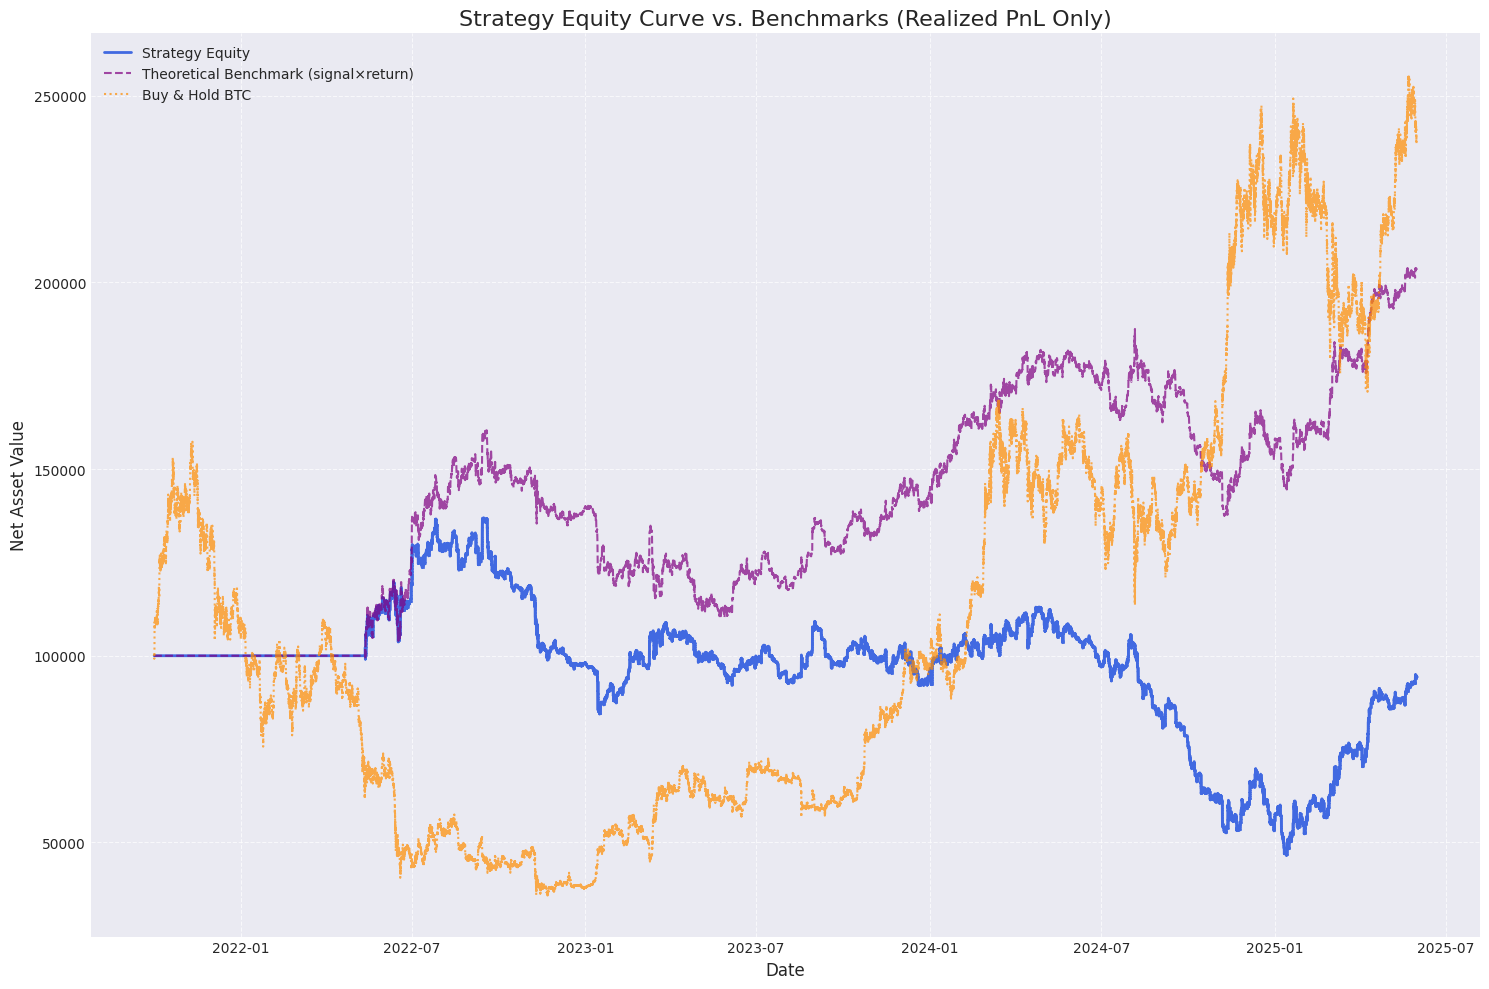

2025-08-08 00:59:32,575 - INFO - ‚úÖ Á≠ñÁï•ËØÑ‰º∞Êä•ÂëäÁîüÊàêÂÆåÊØï„ÄÇ


In [33]:
if __name__ == '__main__':
    # --- 0. CPUÊ†∏ÂøÉÊï∞ÈÖçÁΩÆ ---
    NUM_THREADS = 16
    tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
    tf.config.threading.set_inter_op_parallelism_threads(4)
    logging.info(f"üîß TensorFlowÂ∑≤ÈÖçÁΩÆ‰∏∫‰ΩøÁî®ÊúÄÂ§ö {NUM_THREADS} ‰∏™ intra-op Ê†∏ÂøÉÂíå 4 ‰∏™ inter-op Ê†∏ÂøÉ„ÄÇ")

    # --- 1. ÂèÇÊï∞ÈÖçÁΩÆ ---
    FACTOR_FILE = '/public/data/factor_data/BTCUSDT_15m_2020_2025_factor_data.pkl'
    
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    HOLDING_PERIOD = 10
    
    LOOKBACK_PERIOD = 60
    N_SPLITS = 5

    # --- Âõ†Â≠êÁ≠õÈÄâÊµÅÁ®ãÈÖçÁΩÆ ---
    SCREENING_CONFIG = {
        # ÂõûÊµãÂèÇÊï∞
        'initial_capital': INITIAL_CAPITAL,
        'commission_rate': COMMISSION_RATE,
        'holding_period': HOLDING_PERIOD,
        
        # --- FIX: Ê∑ªÂä† 'rolling_window' ÈÖçÁΩÆ ---
        # Èò∂ÊÆµ‰∏Ä: Ë¥®ÈáèÊåáÊ†áÈòàÂÄº
        # 15ÂàÜÈíübar, ‰∏ÄÂ§©96‰∏™, 10Â§©Á∫¶960‰∏™bar, ‰Ωú‰∏∫‰∏Ä‰∏™ÂêàÁêÜÁöÑÊªöÂä®Á™óÂè£
        'rolling_window': 96 * 10, 
        'rank_ic_threshold': 0.01,
        'ir_threshold': 0.3,
        
        # Èò∂ÊÆµ‰∫å: ÂõûÊµãË°®Áé∞ÈòàÂÄº
        'sharpe_threshold': 2.0,
        'calmar_threshold': 5.0,
        'expectancy_threshold': 0.25,
        'mdd_threshold': 0.20,
        'weekly_trades_threshold': 5
    }

    # --- 2. Âä†ËΩΩÂõ†Â≠êÊï∞ÊçÆ ---
    logging.info(f"üìÇ ‰ªé {FACTOR_FILE} Âä†ËΩΩÂõ†Â≠êÊï∞ÊçÆ...")
    try:
        # ‰ΩøÁî® with open Á°Æ‰øùÊñá‰ª∂Ê≠£Á°ÆÂÖ≥Èó≠
        with open(FACTOR_FILE, 'rb') as f:
            factor_data = pickle.load(f)
        factor_data.index = pd.to_datetime(factor_data.index)
        close_prices = factor_data['close'].copy()
        logging.info(f"‚úÖ Êï∞ÊçÆÂä†ËΩΩÊàêÂäü - ÂΩ¢Áä∂: {factor_data.shape}")
        logging.info(f"üìÖ Êó∂Èó¥ËåÉÂõ¥: {factor_data.index[0]} Ëá≥ {factor_data.index[-1]}")
    except Exception as e:
        logging.error(f"‚ùå Âä†ËΩΩÊï∞ÊçÆÊó∂ÂèëÁîüÈîôËØØ: {e}")
        factor_data = None

    # --- 3. Êï¥Âêà‰∫ÜÂõ†Â≠êÁ≠õÈÄâÁöÑÂÆåÊï¥ÈÄªËæëÊµÅ (Â∏¶ÂõûÈÄÄÊú∫Âà∂) ---
    if factor_data is not None:
        # 3.1 ÊâßË°å‰∏§Èò∂ÊÆµÂõ†Â≠êÁ≠õÈÄâ
        elite_factors, first_stage_factors = screen_factors_sequentially(factor_data, SCREENING_CONFIG)
        
        factors_for_model = []
        # ÂÆûÁé∞ÂõûÈÄÄÈÄªËæë
        if elite_factors:
            logging.info(f"üéâ ÊàêÂäüÁ≠õÈÄâÂá∫ {len(elite_factors)} ‰∏™Á≤æËã±Âõ†Â≠êÔºåÂ∞ÜÁî®‰∫éÊ®°ÂûãËÆ≠ÁªÉ„ÄÇ")
            factors_for_model = elite_factors
        elif first_stage_factors:
            logging.warning(f"‚ö†Ô∏è Êú™Á≠õÈÄâÂá∫‰ªª‰ΩïÁ≤æËã±Âõ†Â≠ê„ÄÇÂõûÈÄÄ‰ΩøÁî®ÈÄöËøáÁ¨¨‰∏ÄÈò∂ÊÆµIC/IRÂàùÁ≠õÁöÑ {len(first_stage_factors)} ‰∏™Âõ†Â≠êËøõË°åÊ®°ÂûãËÆ≠ÁªÉ„ÄÇ")
            factors_for_model = first_stage_factors
        else:
            logging.error("‚ùå Ê≤°Êúâ‰ªª‰ΩïÂõ†Â≠êËÉΩÈÄöËøá‰ªª‰ΩïÈò∂ÊÆµÁöÑÁ≠õÈÄâÔºåÊó†Ê≥ïÁªßÁª≠ËÆ≠ÁªÉÊ®°Âûã„ÄÇËØ∑Ê£ÄÊü•Âõ†Â≠êË¥®ÈáèÊàñÂ§ßÂπÖÊîæÂÆΩÁ≠õÈÄâÊ†áÂáÜ„ÄÇ")

        # Âè™ÊúâÂú®ÊúâÂèØÁî®Âõ†Â≠êÁöÑÊÉÖÂÜµ‰∏ãÊâçÁªßÁª≠
        if factors_for_model:
            logging.info(f"ÊúÄÁªàÁî®‰∫éËÆ≠ÁªÉÁöÑÂõ†Â≠êÂàóË°® ({len(factors_for_model)}‰∏™): {factors_for_model}")
            try:
                # 3.2 ‰ΩøÁî®ÈÄâÂÆöÁöÑÂõ†Â≠êÈõÜÂáÜÂ§áÊï∞ÊçÆ
                X, y, indices, pca, selector = prepare_rolling_data(
                    factor_data, 
                    selected_features=factors_for_model, 
                    lookback=LOOKBACK_PERIOD
                )
                
                # 3.3 ÊâßË°åÊªöÂä®ËÆ≠ÁªÉÂπ∂ÁîüÊàêÊúÄÁªàÊ®°Âûã‰ø°Âè∑
                signals = rolling_train_and_predict(X, y, indices, lookback=LOOKBACK_PERIOD, n_splits=N_SPLITS)
                
                # 3.4 ÂàõÂª∫‰∏éÂéüÂßãÊï∞ÊçÆÂØπÈΩêÁöÑÂÆåÊï¥‰ø°Âè∑Â∫èÂàó
                full_signals = pd.Series(0, index=factor_data.index)
                full_signals.loc[signals.index] = signals
                
                # 3.5 ÂØπÊúÄÁªàÊ®°ÂûãËøõË°åÂõûÊµã‰∏éËØÑ‰º∞
                logging.info("‚úÖ ÊúÄÁªàÊ®°Âûã‰ø°Âè∑ÁîüÊàêÂÆåÊØïÔºåÂºÄÂßãËøõË°åÊúÄÁªàÂõûÊµã‰∏éËØÑ‰º∞...")
                
                backtest_results, trade_history = run_realized_pnl_backtest(
                    prices=close_prices,
                    signals=full_signals,
                    initial_capital=INITIAL_CAPITAL,
                    commission_rate=COMMISSION_RATE,
                    holding_period=HOLDING_PERIOD
                )

                evaluate_realized_pnl_performance(
                    backtest_results,
                    trade_history,
                    INITIAL_CAPITAL
                )
            except Exception as e:
                logging.error(f"‚ùå Âú®Ê®°ÂûãËÆ≠ÁªÉÊàñÊúÄÁªàÂõûÊµãËøáÁ®ã‰∏≠ÂèëÁîüÈîôËØØ: {e}", exc_info=True)

    else:
        logging.warning("‚ö†Ô∏è Áî±‰∫éÊï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•ÔºåË∑≥ËøáÊâÄÊúâÂêéÁª≠Ê≠•È™§„ÄÇ")